---
title: Picture classification (cat or dog)
author: Jamel Belgacem
date: 'July 27, 2023'
categories: [Deep learning, Picture classification]
image: "image_catdog.PNG"
format:
    html:
        code-fold: true
        code-tools: true
        code-link: true
---

# Introduction
Deep learning is a subset of artificial intelligence that involves training neural networks to learn and recognize patterns from vast amounts of data. One of its prominent applications is image classification, where deep learning models can automatically identify objects and features within images. 

In this tutorial I will use a keras neural network to try to predict the class of a picture (Cat / Dog).

You can download the dataset from [Kaggle](www.kaggle.com).

Keras is an open-source deep learning framework that provides a user-friendly interface to build, train, and deploy neural networks. It is designed to be simple and intuitive, making it an ideal choice for beginners and researchers alike.

### Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Keras
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array

# Pre-trained VGG16 model
from keras.applications.vgg16 import VGG16

# Confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Download picture from URL on temporary folder
import urllib.request
import tempfile

### Read data
The dataset is composed from from two folders (train and test), and each of this folder contains pictures already classed in two folders (cats and dogs)

To read the data, we'll use the function [image_dataset_from_directory](tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) of Keras.

We give simply the path of the pictures and it generates a tensorflow datset.

Some arguments can be passed as the picture size (by defalut 256,256) and the size of the batches.

In [9]:
train_dir = 'data/train'
test_dir = 'data/test'

seed_train_validation = 42

generator = ImageDataGenerator(rescale = 1./255,
                               rotation_range=10,
                               zoom_range=0.05,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.15,
                               horizontal_flip=True,
                               validation_split=0.2,
                               fill_mode="nearest")
train_dataset = generator.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, subset='training', seed=seed_train_validation,class_mode = "categorical")
validation_dataset = generator.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, subset='validation', seed=seed_train_validation,class_mode = "categorical")
test_dataset = generator.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32,class_mode = "categorical")

Found 447 images belonging to 2 classes.


Found 110 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [10]:

# building neural networks
model = keras.Sequential([
    # Conv layer 1:
    keras.layers.Conv2D(256, (3, 3), input_shape=(128,128,3), activation='relu', kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    
    # Conv layer 2:
    keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    
    # Conv layer 3:
    keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    
    keras.layers.Flatten(),
    
    # fully connected layers:
    keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer="he_normal"),
    keras.layers.Dense(units =2, activation = 'sigmoid')
    
])

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics ='accuracy')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 batch_normalization_3 (Batc  (None, 126, 126, 256)    1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 256)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 128)       295040    
                                                                 
 batch_normalization_4 (Batc  (None, 61, 61, 128)      512       
 hNormalization)                                                 
                                                      

In [11]:
callback = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
logs = model.fit(train_dataset, epochs=10, validation_data=validation_dataset,validation_steps=2000/32, callbacks=[callback])

Epoch 1/10
14/14 [==============================] - 11s 778ms/step - loss: 0.8652 - accuracy: 0.5794 - val_loss: 0.7048 - val_accuracy: 0.4909
Epoch 2/10
14/14 [==============================] - 10s 699ms/step - loss: 0.7338 - accuracy: 0.6353
Epoch 3/10
14/14 [==============================] - 10s 702ms/step - loss: 0.6750 - accuracy: 0.6644
Epoch 4/10
14/14 [==============================] - 10s 700ms/step - loss: 0.5989 - accuracy: 0.6980
Epoch 5/10
14/14 [==============================] - 10s 729ms/step - loss: 0.5341 - accuracy: 0.7606
Epoch 6/10
14/14 [==============================] - 10s 706ms/step - loss: 0.4934 - accuracy: 0.7808
Epoch 7/10
14/14 [==============================] - 10s 706ms/step - loss: 0.4764 - accuracy: 0.7964
Epoch 8/10
14/14 [==============================] - 10s 701ms/step - loss: 0.4426 - accuracy: 0.7852
Epoch 9/10
14/14 [==============================] - 10s 701ms/step - loss: 0.3846 - accuracy: 0.8345
Epoch 10/10
14/14 [==============================

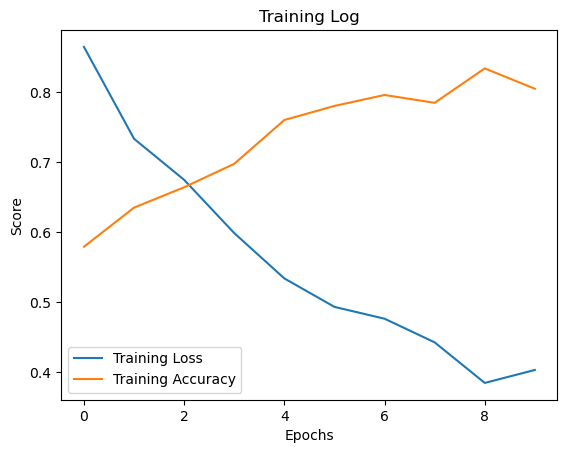

In [12]:
plt.title('Training Log')
plt.plot(logs.history['loss'], label='Training Loss')
plt.plot(logs.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

In [13]:
res = model.evaluate(test_dataset)
accuracy = res[1]
print("Accuracy [perc]: %.1f" %(accuracy*100))

5/5 [==============================] - 1s 166ms/step - loss: 0.8775 - accuracy: 0.4929
Accuracy [perc]: 49.3


The model's low accuracy may be attributed to underfitting, where it fails to capture the complexity of the data, resulting in poor generalization. Alternatively, it could be suffering from overfitting, where the model becomes too specific to the training data and performs poorly on unseen examples.

### with VGG16
VGG16 is a pre-trained convolutional neural network architecture that was introduced as part of the Visual Geometry Group's participation in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014.

It consists of 16 layers, including 13 convolutional layers and 3 fully connected layers, making it deeper than previous models. The network is known for its simplicity and effectiveness in image classification tasks, and its pre-trained weights can be leveraged for transfer learning, allowing developers to use it as a powerful feature extractor for a wide range of visual recognition tasks.

In [14]:
train_dir = 'data/train'
test_dir = 'data/test'

vgg16file = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16 =  VGG16(include_top=False, input_shape=(224,224,3), weights=vgg16file)

# Extract features from images using VGG16 model
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg16.predict(inputs_batch)
        features[i*32:(i+1)*32] = features_batch
        labels[i*32:(i+1)*32] = np.argmax(labels_batch, axis=1)
        i+=1
        if i*32>=sample_count:
            break
    return features, labels

# Specify the directory and the number of samples for feature extraction
generator = ImageDataGenerator(rescale = 1./255,
                               rotation_range=10,
                               zoom_range=0.05,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.15,
                               horizontal_flip=True,
                               validation_split=0.2,
                               fill_mode="nearest")
train_generator = generator.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='categorical', shuffle=True)
train_sample_count = 557
train_features, train_labels = extract_features(train_generator, train_sample_count)
test_generator = generator.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='categorical', shuffle=True)
test_sample_count = 140
test_features, test_labels = extract_features(test_generator, test_sample_count)

Found 557 images belonging to 2 classes.
1/1 [==============================] - 1s 717ms/step
Found 140 images belonging to 2 classes.
1/1 [==============================] - 1s 637ms/step


In [15]:
model2 = Sequential([
    Flatten(input_shape = (7,7,512)),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1,save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
history2 = model2.fit(train_features, train_labels, epochs=20, validation_split=0.2, callbacks=[checkpoint, early])

Epoch 1/20
11/14 [======================>.......] - ETA: 0s - loss: 1.5231 - accuracy: 0.6222
Epoch 1: val_accuracy improved from -inf to 0.77679, saving model to vgg16_1.h5
14/14 [==============================] - 0s 11ms/step - loss: 1.3056 - accuracy: 0.6472 - val_loss: 0.5482 - val_accuracy: 0.7768
Epoch 2/20
10/14 [====================>.........] - ETA: 0s - loss: 0.1794 - accuracy: 0.9375
Epoch 2: val_accuracy did not improve from 0.77679
14/14 [==============================] - 0s 7ms/step - loss: 0.1823 - accuracy: 0.9258 - val_loss: 0.3807 - val_accuracy: 0.7768
Epoch 3/20
11/14 [======================>.......] - ETA: 0s - loss: 0.0690 - accuracy: 0.9858
Epoch 3: val_accuracy improved from 0.77679 to 0.84821, saving model to vgg16_1.h5
14/14 [==============================] - 0s 8ms/step - loss: 0.0667 - accuracy: 0.9865 - val_loss: 0.3448 - val_accuracy: 0.8482
Epoch 4/20
11/14 [======================>.......] - ETA: 0s - loss: 0.0375 - accuracy: 0.9972
Epoch 4: val_accuracy 

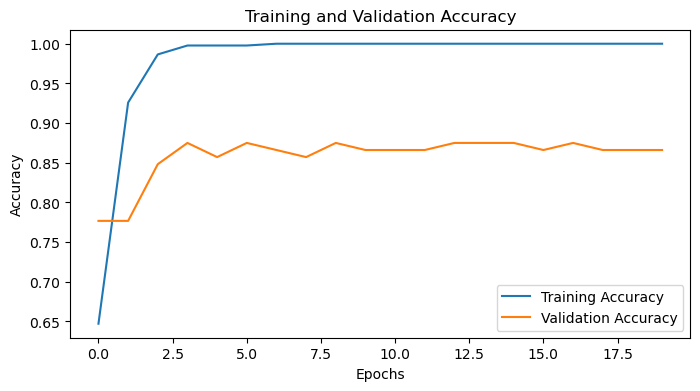

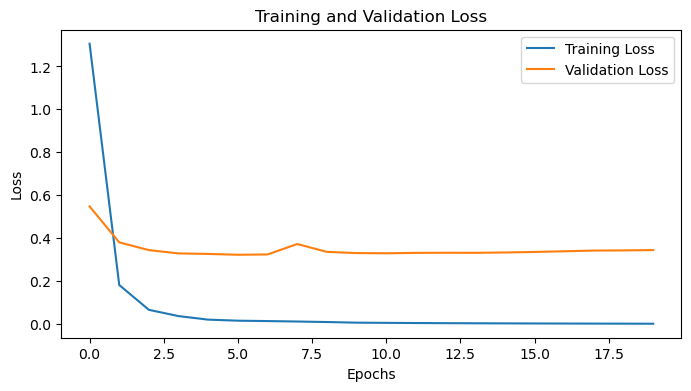

In [16]:

# Get the training and validation accuracy
training_accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']

# Get the training and validation loss
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(8, 4))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
y_prediction = np.argmax(model2.predict(test_features), axis=1)
acc = accuracy_score(y_true=test_labels, y_pred=y_prediction)
print("Accuracy: %.2f" %(acc*100))

5/5 [==============================] - 0s 2ms/step
Accuracy: 81.43


As you see, applying VGG16 as a pre-trained model  has improved the accuracy due to its deep architecture and extensive feature extraction capabilities.

The network's pre-trained weights, learned from a large-scale dataset, enable it to recognize complex patterns and features, making it highly effective in various visual recognition scenarios.

#### Confusion matrix

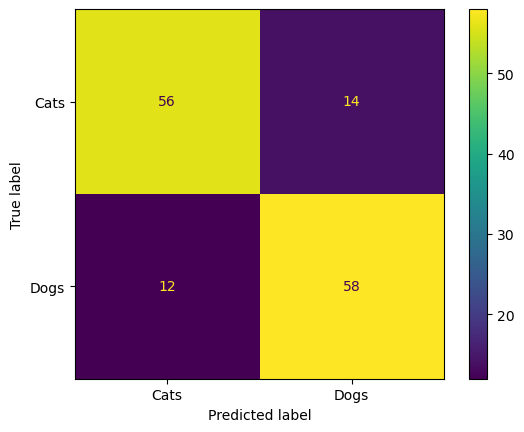

In [18]:
conf_matrix = confusion_matrix(y_true=test_labels, y_pred=y_prediction)
class_labels = ['Cats', 'Dogs']
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot()

### Save models

In [19]:
model2.save('CatsDogs_sequentialModel.h5')
vgg16.save('CatsDogs_vgg16.h5')

#### Test

1/1 [==============================] - 0s 9ms/step
[[9.9997354e-01 2.6435324e-05]]
0
Predicted label: Cats


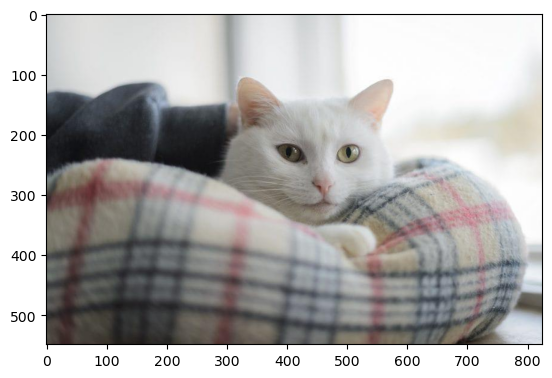

In [20]:
new_image_path ="data/test/cats/cat_355.jpg"
im=plt.imshow(np.asarray(Image.open(new_image_path)))
im

class_labels = ['Cats', 'Dogs']

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    return img


# Preprocess the new image
new_image = preprocess_image(new_image_path)

# Extract features from the new image using VGG16 model
new_features = vgg16.predict(new_image)

# Make prediction on the new image
prediction = model2.predict(new_features)
print(prediction)
predicted_label = np.argmax(prediction)
print(predicted_label)
print("Predicted label:", class_labels[predicted_label])

1/1 [==============================] - 0s 8ms/step
[[0.05162234 0.94837767]]
1
Predicted label: Dogs


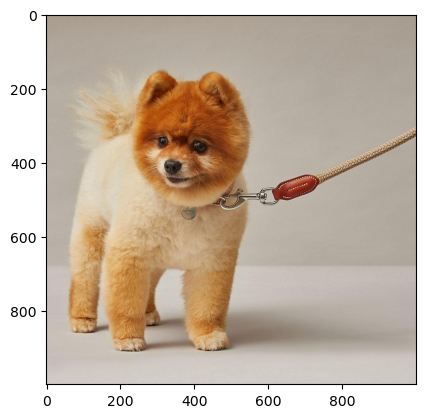

In [21]:
new_image_path ="data/test/dogs/dog_302.jpg"
im=plt.imshow(np.asarray(Image.open(new_image_path)))
im

class_labels = ['Cats', 'Dogs']

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    return img


# Preprocess the new image
new_image = preprocess_image(new_image_path)

# Extract features from the new image using VGG16 model
new_features = vgg16.predict(new_image)

# Make prediction on the new image
prediction = model2.predict(new_features)
print(prediction)
predicted_label = np.argmax(prediction)
print(predicted_label)
print("Predicted label:", class_labels[predicted_label])

1/1 [==============================] - 0s 9ms/step
[[3.1969484e-04 9.9968028e-01]]
1
Predicted label: Dogs


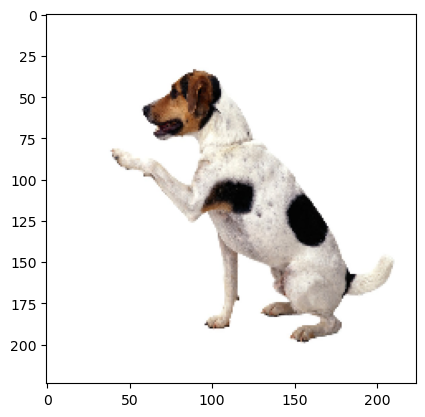

In [22]:
url = "https://images.freeimages.com/images/large-previews/3f8/dog-1383342.jpg"
tempfile_path =tempfile.mktemp()
urllib.request.urlretrieve(url, tempfile_path)


new_image = load_img(tempfile_path, target_size=(224,224))

im=plt.imshow(np.asarray(new_image))
im
new_image = img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)
new_image = new_image / 255.0  # Normalize the image

# Extract features from the new image using VGG16 model
new_features = vgg16.predict(new_image)

# Make prediction on the new image
prediction = model2.predict(new_features)
print(prediction)
predicted_label = np.argmax(prediction)
print(predicted_label)
print("Predicted label:", class_labels[predicted_label])